In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import PIL.Image
import os
from IPython.display import display, clear_output

class StyleTransfer:
    def __init__(self, content_path, style_path, output_dir='style_transfer_progress', content_weight=1e3, style_weight=1e-2):
        self.content_path = content_path
        self.style_path = style_path
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.output_dir = output_dir

        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Image parameters
        self.img_height = 400
        self.img_width = None  # Will be calculated to maintain aspect ratio

        # Content and style layer names
        self.content_layers = ['block5_conv2']
        self.style_layers = ['block1_conv1',
                           'block2_conv1',
                           'block3_conv1',
                           'block4_conv1',
                           'block5_conv1']

        # Add num_style_layers attribute
        self.num_style_layers = len(self.style_layers)

        # Load and preprocess images
        self.content_image = self.load_and_preprocess_image(content_path)
        self.style_image = self.load_and_preprocess_image(style_path)

        # Save original images
        self.save_image(self.content_image, os.path.join(self.output_dir, 'content.jpg'))
        self.save_image(self.style_image, os.path.join(self.output_dir, 'style.jpg'))

        # Set up the model
        self.extractor = self.StyleContentModel(self.style_layers, self.content_layers)

        # Initialize target image
        self.target = tf.Variable(self.content_image)

        # Extract style and content targets
        self.style_targets = self.extractor(self.style_image)['style']
        self.content_targets = self.extractor(self.content_image)['content']

    def load_and_preprocess_image(self, path):
        # Load and resize image maintaining aspect ratio
        img = load_img(path)
        if self.img_width is None:
            aspect_ratio = img.size[0] / img.size[1]
            self.img_width = int(self.img_height * aspect_ratio)

        img = img.resize((self.img_width, self.img_height))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        return img / 255.0  # Scale to [0,1]

    def save_image(self, img_tensor, filename):
        """Save a tensor as an image file"""
        tensor = img_tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)
        tensor = tensor[0]
        img = PIL.Image.fromarray(tensor)
        img.save(filename)

    def display_progress(self, epoch, epochs, loss):
        """Display current progress including images"""
        clear_output(wait=True)

        # Save current result
        current_result = os.path.join(self.output_dir, f'epoch_{epoch:03d}.jpg')
        self.save_image(self.target, current_result)

        # Display progress information
        print(f"Epoch {epoch}/{epochs}")
        print(f"Loss: {loss:.4f}")

        # Display images
        content_img = PIL.Image.open(os.path.join(self.output_dir, 'content.jpg'))
        style_img = PIL.Image.open(os.path.join(self.output_dir, 'style.jpg'))
        result_img = PIL.Image.open(current_result)

        display(PIL.Image.open(os.path.join(self.output_dir, 'content.jpg')))
        print("Content Image ↑")
        display(PIL.Image.open(os.path.join(self.output_dir, 'style.jpg')))
        print("Style Image ↑")
        display(PIL.Image.open(current_result))
        print(f"Result after epoch {epoch} ↑")

    class StyleContentModel(tf.keras.Model):
        def __init__(self, style_layers, content_layers):
            super().__init__()
            self.vgg = self.get_model(style_layers + content_layers)
            self.style_layers = style_layers
            self.content_layers = content_layers
            self.num_style_layers = len(style_layers)

        def get_model(self, layer_names):
            vgg = vgg19.VGG19(include_top=False, weights='imagenet')
            vgg.trainable = False
            outputs = [vgg.get_layer(name).output for name in layer_names]
            model = tf.keras.Model([vgg.input], outputs)
            return model

        def gram_matrix(self, input_tensor):
            result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
            input_shape = tf.shape(input_tensor)
            num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
            return result / num_locations

        def call(self, inputs):
            inputs = tf.cast(inputs, tf.float32)
            inputs = inputs * 255.0
            preprocessed_input = vgg19.preprocess_input(inputs)

            outputs = self.vgg(preprocessed_input)
            if not isinstance(outputs, list):
                outputs = [outputs]

            style_outputs = outputs[:self.num_style_layers]
            content_outputs = outputs[self.num_style_layers:]

            style_outputs = [self.gram_matrix(style_output) for style_output in style_outputs]

            return {
                'content': content_outputs,
                'style': style_outputs
            }

    def style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[i] - self.style_targets[i])**2)
                              for i in range(len(style_outputs))])
        style_loss *= self.style_weight / self.num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[i] - self.content_targets[i])**2)
                                for i in range(len(content_outputs))])
        content_loss *= self.content_weight / len(self.content_layers)

        return style_loss + content_loss

    @tf.function
    def train_step(self, optimizer):
        with tf.GradientTape() as tape:
            outputs = self.extractor(self.target)
            loss = self.style_content_loss(outputs)

        gradients = tape.gradient(loss, self.target)
        optimizer.apply_gradients([(gradients, self.target)])
        self.target.assign(tf.clip_by_value(self.target, 0.0, 1.0))
        return loss

    def train(self, epochs=10, steps_per_epoch=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

        for epoch in range(epochs):
            total_loss = 0
            for step in range(steps_per_epoch):
                loss = self.train_step(optimizer)
                total_loss += loss

            avg_loss = total_loss / steps_per_epoch
            # Display progress after each epoch
            self.display_progress(epoch + 1, epochs, avg_loss)

    def save_result(self, filename):
        self.save_image(self.target, filename)

# Example usage:
"""
style_transfer = StyleTransfer(
    content_path='content_image.jpg',
    style_path='style_image.jpg',
    output_dir='style_transfer_progress'
)

style_transfer.train(epochs=10, steps_per_epoch=100)
style_transfer.save_result('final_result.jpg')
"""

"\nstyle_transfer = StyleTransfer(\n    content_path='content_image.jpg',\n    style_path='style_image.jpg',\n    output_dir='style_transfer_progress'\n)\n\nstyle_transfer.train(epochs=10, steps_per_epoch=100)\nstyle_transfer.save_result('final_result.jpg')\n"

Epoch 1/10
Loss: 502889280.0000


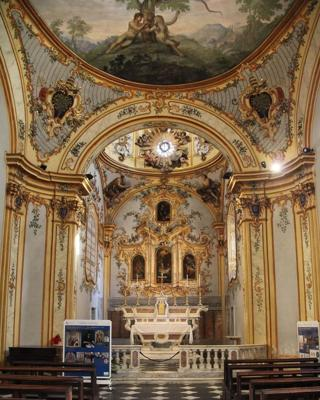

Content Image ↑


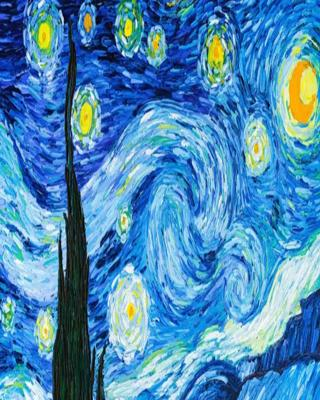

Style Image ↑


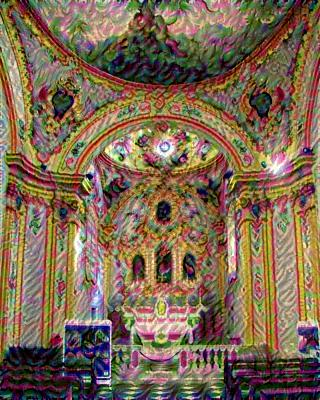

Result after epoch 1 ↑


KeyboardInterrupt: 

In [25]:
# Initialize the model
style_transfer = StyleTransfer(
    content_path='chapel.png',
    style_path='sn.png',
    content_weight=1e3,
    style_weight=1e-2
)

# Train the model
style_transfer.train(epochs=10, steps_per_epoch=10)

# Save the result
style_transfer.save_result('styled_image.jpg')

In [35]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import PIL.Image
import os
from IPython.display import display, clear_output

class StyleTransfer:
    def __init__(self, content_path=None, style_path=None, output_dir='style_transfer_progress', content_weight=1e3, style_weight=1e-2):
        self.content_path = content_path
        self.style_path = style_path
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.output_dir = output_dir

        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Image parameters
        self.img_height = 400
        self.img_width = None  # Will be calculated to maintain aspect ratio

        # Content and style layer names
        self.content_layers = ['block5_conv2']
        self.style_layers = ['block1_conv1',
                           'block2_conv1',
                           'block3_conv1',
                           'block4_conv1',
                           'block5_conv1']

        # Add num_style_layers attribute
        self.num_style_layers = len(self.style_layers)

        # Load and preprocess images if paths are provided
        if content_path and style_path:
            self.content_image = self.load_and_preprocess_image(content_path)
            self.style_image = self.load_and_preprocess_image(style_path)

            # Save original images
            self.save_image(self.content_image, os.path.join(self.output_dir, 'content.jpg'))
            self.save_image(self.style_image, os.path.join(self.output_dir, 'style.jpg'))

            # Set up the model
            self.extractor = self.StyleContentModel(self.style_layers, self.content_layers)

            # Initialize target image
            self.target = tf.Variable(self.content_image)

            # Extract style and content targets
            self.style_targets = self.extractor(self.style_image)['style']
            self.content_targets = self.extractor(self.content_image)['content']

    def load_and_preprocess_image(self, path):
        # Load and resize image maintaining aspect ratio
        img = load_img(path)
        if self.img_width is None:
            aspect_ratio = img.size[0] / img.size[1]
            self.img_width = int(self.img_height * aspect_ratio)

        img = img.resize((self.img_width, self.img_height))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        return img / 255.0  # Scale to [0,1]

    def save_image(self, img_tensor, filename):
        """Save a tensor as an image file"""
        tensor = img_tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)
        tensor = tensor[0]
        img = PIL.Image.fromarray(tensor)
        img.save(filename)

    def display_progress(self, epoch, epochs, loss):
        """Display current progress including images"""
        clear_output(wait=True)

        # Save current result
        current_result = os.path.join(self.output_dir, f'epoch_{epoch:03d}.jpg')
        self.save_image(self.target, current_result)

        # Display progress information
        print(f"Epoch {epoch}/{epochs}")
        print(f"Loss: {loss:.4f}")

        # Display images
        content_img = PIL.Image.open(os.path.join(self.output_dir, 'content.jpg'))
        style_img = PIL.Image.open(os.path.join(self.output_dir, 'style.jpg'))
        result_img = PIL.Image.open(current_result)

        display(PIL.Image.open(os.path.join(self.output_dir, 'content.jpg')))
        print("Content Image ↑")
        display(PIL.Image.open(os.path.join(self.output_dir, 'style.jpg')))
        print("Style Image ↑")
        display(PIL.Image.open(current_result))
        print(f"Result after epoch {epoch} ↑")

    class StyleContentModel(tf.keras.Model):
        def __init__(self, style_layers, content_layers):
            super().__init__()
            self.vgg = self.get_model(style_layers + content_layers)
            self.style_layers = style_layers
            self.content_layers = content_layers
            self.num_style_layers = len(style_layers)

        def get_model(self, layer_names):
            vgg = vgg19.VGG19(include_top=False, weights='imagenet')
            vgg.trainable = False
            outputs = [vgg.get_layer(name).output for name in layer_names]
            model = tf.keras.Model([vgg.input], outputs)
            return model

        def gram_matrix(self, input_tensor):
            result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
            input_shape = tf.shape(input_tensor)
            num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
            return result / num_locations

        def call(self, inputs):
            inputs = tf.cast(inputs, tf.float32)
            inputs = inputs * 255.0
            preprocessed_input = vgg19.preprocess_input(inputs)

            outputs = self.vgg(preprocessed_input)
            if not isinstance(outputs, list):
                outputs = [outputs]

            style_outputs = outputs[:self.num_style_layers]
            content_outputs = outputs[self.num_style_layers:]

            style_outputs = [self.gram_matrix(style_output) for style_output in style_outputs]

            return {
                'content': content_outputs,
                'style': style_outputs
            }

    def style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[i] - self.style_targets[i])**2)
                              for i in range(len(style_outputs))])
        style_loss *= self.style_weight / self.num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[i] - self.content_targets[i])**2)
                                for i in range(len(content_outputs))])
        content_loss *= self.content_weight / len(self.content_layers)

        return style_loss + content_loss

    @tf.function
    def train_step(self, optimizer):
        with tf.GradientTape() as tape:
            outputs = self.extractor(self.target)
            loss = self.style_content_loss(outputs)

        gradients = tape.gradient(loss, self.target)
        optimizer.apply_gradients([(gradients, self.target)])
        self.target.assign(tf.clip_by_value(self.target, 0.0, 1.0))
        return loss

    def train(self, epochs=10, steps_per_epoch=100):
        optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

        for epoch in range(epochs):
            total_loss = 0
            for step in range(steps_per_epoch):
                loss = self.train_step(optimizer)
                total_loss += loss

            avg_loss = total_loss / steps_per_epoch
            # Display progress after each epoch
            self.display_progress(epoch + 1, epochs, avg_loss)

    def save_result(self, filename):
        self.save_image(self.target, filename)

    def save_model(self, model_path):
        """Save the current model and its weights"""
        self.extractor.save_weights(model_path)
        print(f"Model saved to {model_path}")

    def load_model(self, model_path):
        """Load a previously saved model"""
        # Reinitialize the extractor
        self.extractor = self.StyleContentModel(self.style_layers, self.content_layers)

        # Build the model by passing a dummy input
        dummy_input = tf.random.normal([1, self.img_height, self.img_width, 3])
        _ = self.extractor(dummy_input)  # This builds the model

        # Load the weights
        self.extractor.load_weights(model_path)
        print(f"Model loaded from {model_path}")

    def apply_style(self, content_path, output_path):
        """Apply the style to a new content image without training"""
        content_image = self.load_and_preprocess_image(content_path)
        self.target = tf.Variable(content_image)

        # Extract content targets for the new image
        self.content_targets = self.extractor(content_image)['content']

        # Apply style transfer
        optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        for _ in range(100):  # You can adjust the number of steps
            self.train_step(optimizer)

        # Save the result
        self.save_image(self.target, output_path)
        print(f"Style applied and saved to {output_path}")

Epoch 10/10
Loss: 86936672.0000


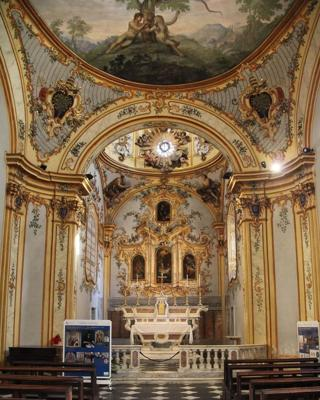

Content Image ↑


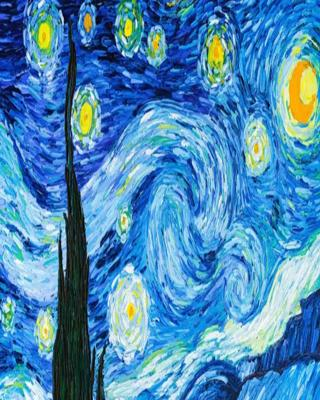

Style Image ↑


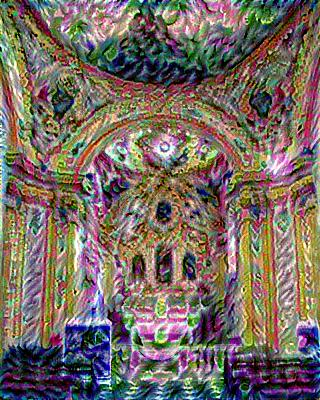

Result after epoch 10 ↑


ValueError: The filename must end in `.weights.h5`. Received: filepath=style_transfer_model.h5

In [30]:
# Initialize StyleTransfer with content and style images
st = StyleTransfer(content_path='chapel.png', style_path='sn.png')

# Train the model
st.train(epochs=10,steps_per_epoch=3)



